In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Create a SparkSession
spark = SparkSession.builder\
    .appName("Flights")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

# Set the partitions to 4 or 8.
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [3]:
# Import the data
spark.catalog.clearCache()
flights18_df = spark.read.csv("sample_data/data/2018.csv", inferSchema=True, sep=",", header=True)
flights18_df.show()
flights18_df.count()


+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

7213446

In [4]:
# Convert date columns into Month, Day, Weekday
# Add a Delay column based on the DEP_DELAY or ARR_DELAY
from pyspark.sql import functions as f
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

flights_df = flights18_df.withColumn("Month", month(flights18_df['FL_DATE']))\
                         .withColumn("Day", dayofmonth(flights18_df['FL_DATE']))\
                         .withColumn("Weekday", dayofweek(flights18_df['FL_DATE']))\
                         .withColumn("Delay", f.when((f.col("DEP_DELAY") > 0) | (f.col("ARR_DELAY") > 0), 1)\
                                       .otherwise(0))
flights_df.show()
flights_df.count()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-----+---+-------+-----+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|Month|Day|Weekday|Delay|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+-

7213446

In [5]:
# Create a view for easy data manipulation
flights_df.createOrReplaceTempView("flights")

In [6]:
# Get top 5 airlines, 5 Origin and 5 Dest
filter_df = spark.sql("""
SELECT * FROM flights WHERE op_carrier in ("WN", "AA", "DL", "OO", "UA")
AND Origin in ("ATL", "ORD", "DFW", "CLT", "DEN")
AND Dest in ("ATL", "ORD", "DFW", "CLT", "DEN")
""")
filter_df.show()
filter_df.count()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-----+---+-------+-----+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|Month|Day|Weekday|Delay|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+-

100170

In [7]:
# Check if CANCELLATION_CODE has any significance of the Delay reasons
spark.sql("""
SELECT DISTINCT CANCELLATION_CODE,
CARRIER_DELAY,
WEATHER_DELAY,
NAS_DELAY,
SECURITY_DELAY,
LATE_AIRCRAFT_DELAY
FROM flights
WHERE CANCELLATION_CODE IS NOT NULL
""").show()

+-----------------+-------------+-------------+---------+--------------+-------------------+
|CANCELLATION_CODE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+-----------------+-------------+-------------+---------+--------------+-------------------+
|                B|         null|         null|     null|          null|               null|
|                C|         null|         null|     null|          null|               null|
|                A|         null|         null|     null|          null|               null|
|                D|         null|         null|     null|          null|               null|
+-----------------+-------------+-------------+---------+--------------+-------------------+



In [8]:
# Remove columns which is not going to help in predictions
flights_cleaned_df = filter_df.drop("FL_DATE", "OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "DEP_TIME", "DEP_DELAY", "CRS_ARR_TIME", "ARR_TIME", "ARR_DELAY",\
                                    "CANCELLATION_CODE", "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY", "Unnamed: 27")
flights_cleaned_df.show()
flights_cleaned_df.count()

+----------+------+----+--------+----------+---------+-------+---------+--------+----------------+-------------------+--------+--------+-----+---+-------+-----+
|OP_CARRIER|ORIGIN|DEST|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|Month|Day|Weekday|Delay|
+----------+------+----+--------+----------+---------+-------+---------+--------+----------------+-------------------+--------+--------+-----+---+-------+-----+
|        UA|   DEN| ORD|    12.0|     921.0|   1216.0|   19.0|      0.0|     0.0|           147.0|              146.0|   115.0|   888.0|    1|  1|      2|    0|
|        UA|   ORD| CLT|    16.0|    2143.0|   2359.0|    4.0|      0.0|     0.0|           122.0|               96.0|    76.0|   599.0|    1|  1|      2|    1|
|        UA|   ORD| DEN|    18.0|    1400.0|   1511.0|    8.0|      0.0|     0.0|           162.0|              157.0|   131.0|   888.0|    1|  1|      2|    0|
|        UA|   ORD| DEN|    18.0| 

100170

In [9]:
# Conver to Pandas DataFrame
pflights_df = flights_cleaned_df.toPandas()
pflights_df.head()

,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,Month,Day,Weekday,Delay
0,UA,DEN,ORD,12.0,921.0,1216.0,19.0,0.0,0.0,147.0,146.0,115.0,888.0,1,1,2,0
1,UA,ORD,CLT,16.0,2143.0,2359.0,4.0,0.0,0.0,122.0,96.0,76.0,599.0,1,1,2,1
2,UA,ORD,DEN,18.0,1400.0,1511.0,8.0,0.0,0.0,162.0,157.0,131.0,888.0,1,1,2,0
3,UA,ORD,DEN,18.0,2304.0,6.0,6.0,0.0,0.0,165.0,146.0,122.0,888.0,1,1,2,1
4,UA,DFW,DEN,13.0,920.0,955.0,16.0,0.0,0.0,130.0,124.0,95.0,641.0,1,1,2,0


In [10]:
# Replace NaN with zeros
pflights_df = pflights_df.fillna(0)
pflights_df.head()

,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,Month,Day,Weekday,Delay
0,UA,DEN,ORD,12.0,921.0,1216.0,19.0,0.0,0.0,147.0,146.0,115.0,888.0,1,1,2,0
1,UA,ORD,CLT,16.0,2143.0,2359.0,4.0,0.0,0.0,122.0,96.0,76.0,599.0,1,1,2,1
2,UA,ORD,DEN,18.0,1400.0,1511.0,8.0,0.0,0.0,162.0,157.0,131.0,888.0,1,1,2,0
3,UA,ORD,DEN,18.0,2304.0,6.0,6.0,0.0,0.0,165.0,146.0,122.0,888.0,1,1,2,1
4,UA,DFW,DEN,13.0,920.0,955.0,16.0,0.0,0.0,130.0,124.0,95.0,641.0,1,1,2,0


In [11]:
# See unique values from all columns
pflights_df.nunique()

OP_CARRIER                5
ORIGIN                    5
DEST                      5
TAXI_OUT                151
WHEELS_OFF             1297
WHEELS_ON              1363
TAXI_IN                 116
CANCELLED                 2
DIVERTED                  2
CRS_ELAPSED_TIME        164
ACTUAL_ELAPSED_TIME     265
AIR_TIME                217
DISTANCE                 11
Month                    12
Day                      31
Weekday                   7
Delay                     2
dtype: int64

In [12]:
# Choose y and show
y = pflights_df["Delay"]
y.head()

0    0
1    1
2    0
3    1
4    0
Name: Delay, dtype: int32

In [13]:
# Choose X and show
X = pflights_df.drop(columns="Delay")
X.head()

,OP_CARRIER,ORIGIN,DEST,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,Month,Day,Weekday
0,UA,DEN,ORD,12.0,921.0,1216.0,19.0,0.0,0.0,147.0,146.0,115.0,888.0,1,1,2
1,UA,ORD,CLT,16.0,2143.0,2359.0,4.0,0.0,0.0,122.0,96.0,76.0,599.0,1,1,2
2,UA,ORD,DEN,18.0,1400.0,1511.0,8.0,0.0,0.0,162.0,157.0,131.0,888.0,1,1,2
3,UA,ORD,DEN,18.0,2304.0,6.0,6.0,0.0,0.0,165.0,146.0,122.0,888.0,1,1,2
4,UA,DFW,DEN,13.0,920.0,955.0,16.0,0.0,0.0,130.0,124.0,95.0,641.0,1,1,2


In [14]:
# Convert Non-numeric values using get_dummies
X = pd.get_dummies(X)
X.head()
X.columns

Index(['TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CANCELLED',
       'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'Month', 'Day', 'Weekday', 'OP_CARRIER_AA', 'OP_CARRIER_DL',
       'OP_CARRIER_OO', 'OP_CARRIER_UA', 'OP_CARRIER_WN', 'ORIGIN_ATL',
       'ORIGIN_CLT', 'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_ORD', 'DEST_ATL',
       'DEST_CLT', 'DEST_DEN', 'DEST_DFW', 'DEST_ORD'],
      dtype='object')

In [15]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.35)

In [16]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# Create a Logistic Regression model
classifier = LogisticRegression(solver='newton-cholesky', random_state=1)
classifier

LogisticRegression(random_state=1, solver='newton-cholesky')

In [18]:
# Train the data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1, solver='newton-cholesky')

In [19]:
# Print the Data Score
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.4835201965903855
Testing Data Score: 0.48126069594980037


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [20]:
# Predict the model
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Prediction,Actual
66574,1,1
81479,1,1
22759,1,1
84556,1,1
7155,1,0
...,...,...
74550,1,1
66063,1,0
44217,1,1
21471,1,1


In [21]:
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.48126069594980037

In [22]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [23]:
 # Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [24]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [25]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [26]:
 # Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,16141,2334
Actual 1,4214,12371


Accuracy Score : 0.8132344552196235
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     18475
           1       0.84      0.75      0.79     16585

    accuracy                           0.81     35060
   macro avg       0.82      0.81      0.81     35060
weighted avg       0.82      0.81      0.81     35060



In [27]:
 # Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.14919199494711363, 'WHEELS_OFF'),
 (0.13713533912938325, 'WHEELS_ON'),
 (0.11561900507872976, 'ACTUAL_ELAPSED_TIME'),
 (0.11063310715508988, 'TAXI_OUT'),
 (0.08593179289999034, 'CRS_ELAPSED_TIME'),
 (0.08002641341168522, 'AIR_TIME'),
 (0.06779471659487701, 'Day'),
 (0.06663990832667414, 'TAXI_IN'),
 (0.05370323529024548, 'Month'),
 (0.04309058812011259, 'Weekday'),
 (0.019434764960982984, 'DISTANCE'),
 (0.008457166509381582, 'OP_CARRIER_AA'),
 (0.006288986329397906, 'OP_CARRIER_UA'),
 (0.005767912059464803, 'DEST_ORD'),
 (0.00517518900266727, 'OP_CARRIER_DL'),
 (0.004955853071463429, 'ORIGIN_ATL'),
 (0.004861390367104154, 'ORIGIN_ORD'),
 (0.004707951959422794, 'ORIGIN_DFW'),
 (0.004585851796362047, 'DEST_DFW'),
 (0.0041988138195803125, 'DEST_ATL'),
 (0.004014515001420993, 'ORIGIN_DEN'),
 (0.003880062368540407, 'DEST_DEN'),
 (0.0037149629721762905, 'DEST_CLT'),
 (0.0036550049362654895, 'ORIGIN_CLT'),
 (0.002953645872393046, 'OP_CARRIER_OO'),
 (0.001860501105277529, 'OP_CARRIER_WN'),

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

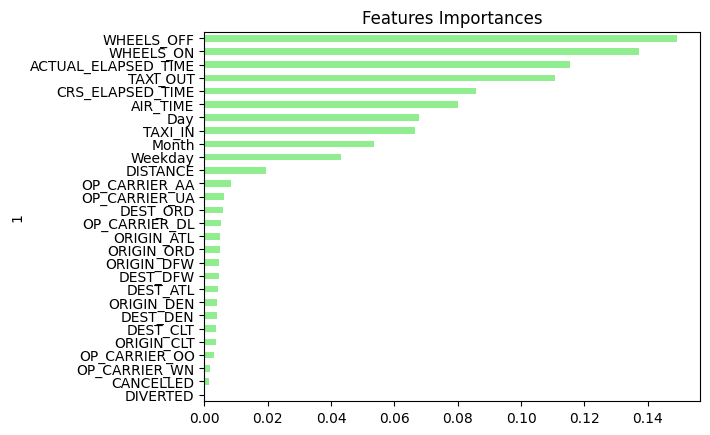

In [28]:
 # Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [36]:
filter_df.toPandas().to_csv("Flights2018.csv")